# Project Description
 - Conducted wind power forecasting for a specific windmill using data spanning 2018 to 2020 at 10-minute intervals.
 - Employed ARIMA, ETS, Theta, and Prophet models to predict mean daily wind power for the next 15 days.

In [16]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sklearn.metrics as skmetrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings                               
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363


In [3]:
df.isnull().sum(), len(df)

(Datetime                            0
 ActivePower                         0
 AmbientTemperatue                 896
 BearingShaftTemperature         26684
 Blade1PitchAngle                43282
 Blade2PitchAngle                43365
 Blade3PitchAngle                43365
 GearboxBearingTemperature       26682
 GearboxOilTemperature           26670
 GeneratorRPM                    26674
 GeneratorWinding1Temperature    26656
 GeneratorWinding2Temperature    26649
 HubTemperature                  26792
 MainBoxTemperature              26704
 NacellePosition                 20424
 ReactivePower                      42
 RotorRPM                        26680
 TurbineStatus                   26466
 WindDirection                   20424
 WindSpeed                         308
 dtype: int64,
 77202)

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df_interpolated = df.interpolate()

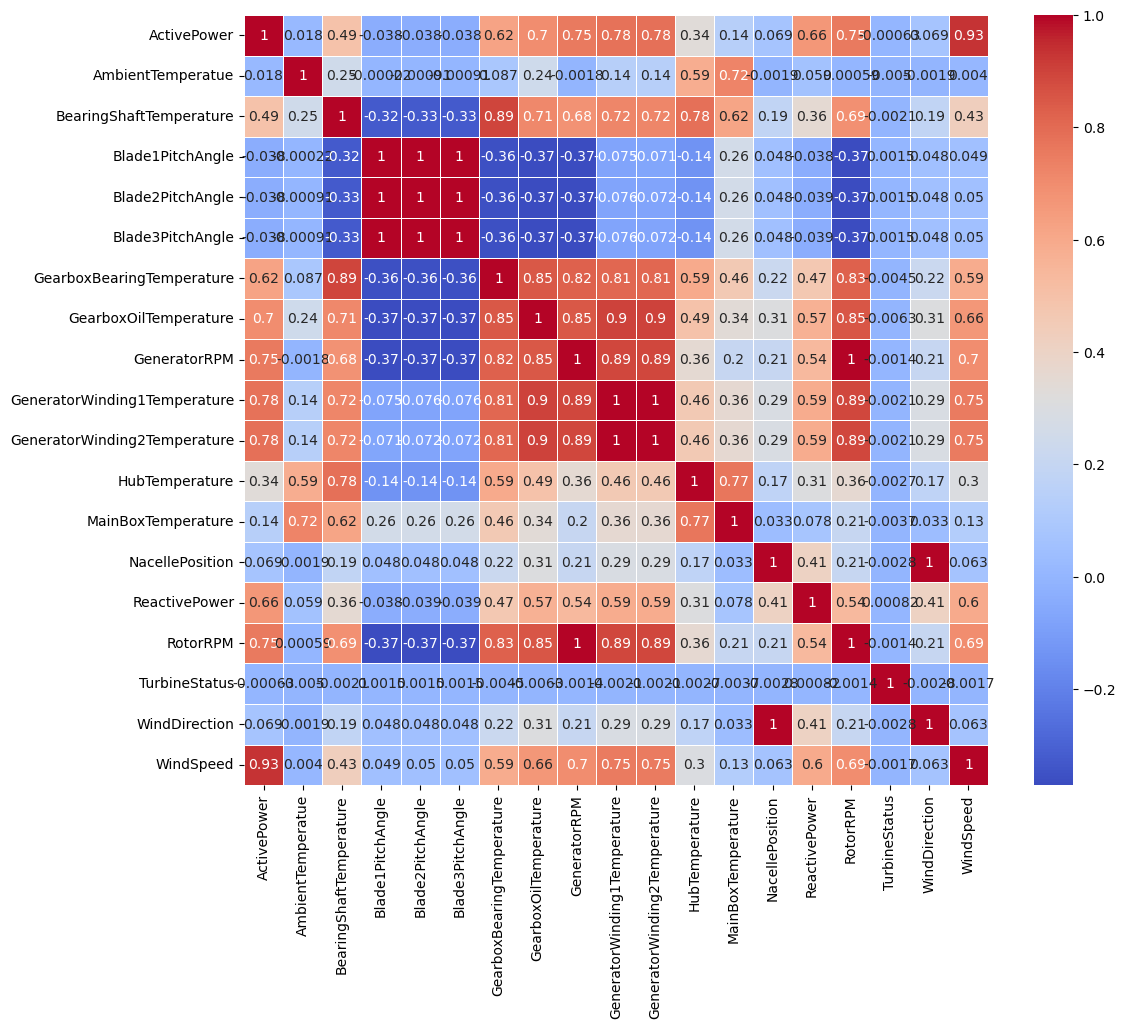

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_interpolated.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()


In [25]:
daily_df = df[['ActivePower', 'WindSpeed']].resample('D').mean()
daily_df.head()

,ActivePower,WindSpeed
Datetime,,
2018-01-01 00:00:00+00:00,366.223561,5.263797
2018-01-02 00:00:00+00:00,462.550740,5.390719
2018-01-03 00:00:00+00:00,454.417752,5.295225
2018-01-04 00:00:00+00:00,369.952190,5.094994
2018-01-05 00:00:00+00:00,319.446595,4.915224


<Axes: xlabel='Datetime'>

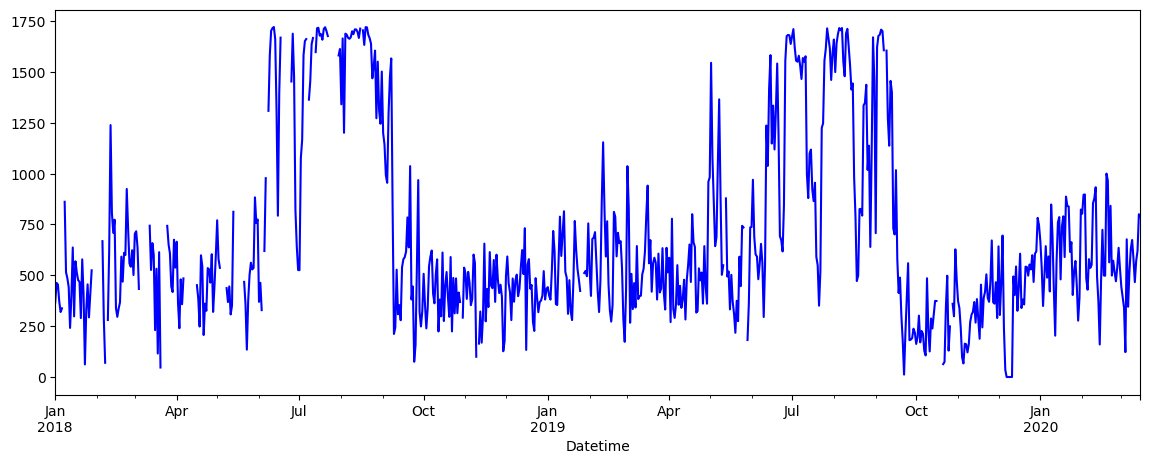

In [7]:
f, ax = plt.subplots(figsize=(14,5))
daily_df['ActivePower'].plot(kind='line',y='0',color='blue', label='history', ax=ax)

In [8]:
#check trend with MA smoothing
#def a moving average plot
def plotMovingAverage(series, window, plot_actual=False, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

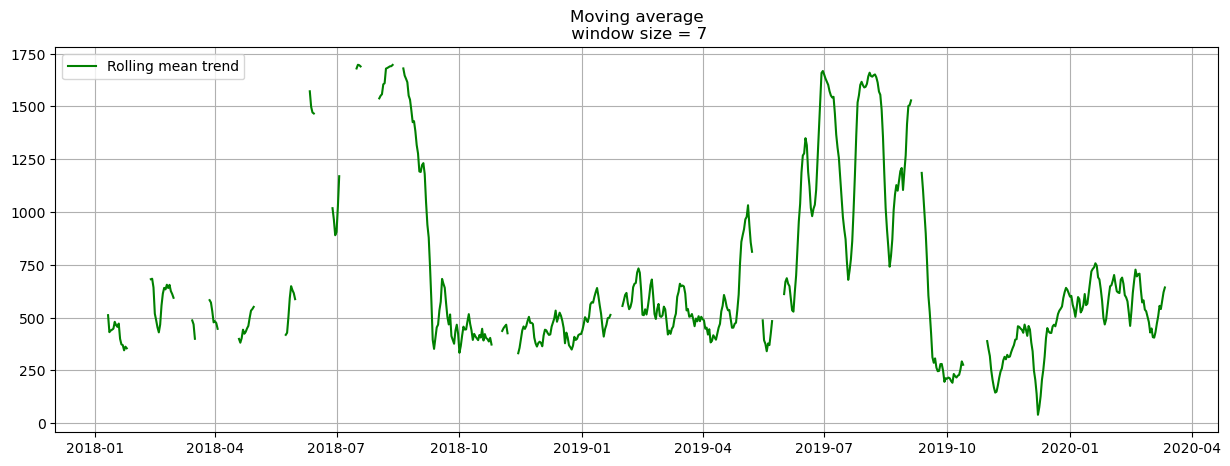

In [9]:
plotMovingAverage(daily_df.ActivePower,7)

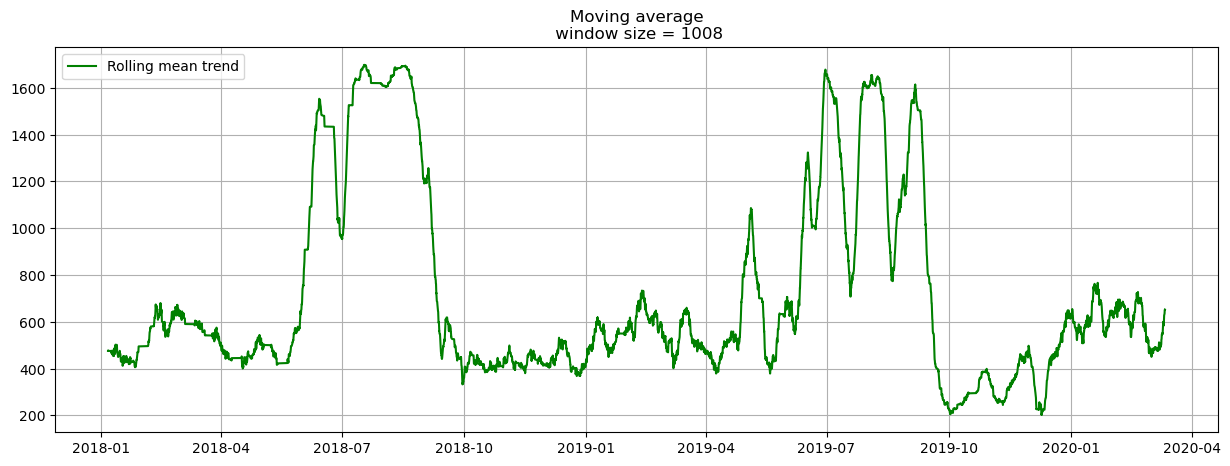

In [10]:
plotMovingAverage(df.ActivePower,1008)

In [11]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
      
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [12]:
adf_test(df.ActivePower)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.522004e+01
p-value                        5.501421e-28
#Lags Used                     6.400000e+01
Number of Observations Used    7.713700e+04
Critical Value (1%)           -3.430435e+00
Critical Value (5%)           -2.861577e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


Visually it just looks like strong seasonal patterns, but no real visible trend. The peaks and averages at lower points are similar across years.

In [38]:
# fill nan with mean
y = daily_df['ActivePower']
mean = y.mean()
daily_df['ActivePower'] = daily_df['ActivePower'].fillna(mean)

In [39]:
daily_df.isnull().sum()

ActivePower     0
WindSpeed      72
dtype: int64

In [40]:
daily_df['ActivePower'] = daily_df['ActivePower'].replace(0, 0.1)
(daily_df['ActivePower'] <= 0).any()

False

In [41]:
history = daily_df[:-15]
test = daily_df[-15:]

### 1. ARIMA Approach:

In [597]:
def sarima_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K = 5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            cfg = [(p, d, q), (P, D, Q, m)]
                            validation_size = 15
                            train_size = len(dataset) - validation_size * K
                            rmse = 0
                            for k in range(K):
                                train, test = dataset[0:train_size + k * validation_size], dataset[train_size + k * validation_size:train_size + (k + 1) * validation_size]
                                model = ARIMA(train['ActivePower'], order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions = model_fit.forecast(validation_size)
                                rmse += np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], predictions))

                            rmse_avg = rmse / K
                            result.append((cfg, rmse_avg))

                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMA%s RMSE=%.3f' % (cfg, rmse_avg))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [599]:
p_values = range(0,2)
d_values = [0]
q_values = range(0,2)
P_values=[1,2]
D_values = [1]
Q_values =[2,3,5]
m = 7

sarima_cv(history, p_values, d_values, q_values, P_values, D_values, Q_values, m)

SARIMA[(0, 0, 0), (1, 1, 2, 7)] RMSE=245.341
SARIMA[(0, 0, 0), (1, 1, 5, 7)] RMSE=238.256
SARIMA[(0, 0, 0), (2, 1, 5, 7)] RMSE=200.788
Best SARIMA[(0, 0, 0), (2, 1, 5, 7)] RMSE=200.788


In [609]:
sarima_model = ARIMA(history['ActivePower'], order=(0,0,2), seasonal_order=(1,1,5,7)).fit()
sarima_pred = sarima_model.forecast(15)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred.set_index(test.index, inplace=True)

In [611]:
sarima_model = ARIMA(history['ActivePower'], order=(0,0,2), seasonal_order=(2,1,3,7)).fit()
sarima_pred = sarima_model.forecast(15)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred.set_index(test.index, inplace=True)

In [612]:
np.sqrt(skmetrics.mean_squared_error(sarima_pred, test.ActivePower))

166.76756604777083

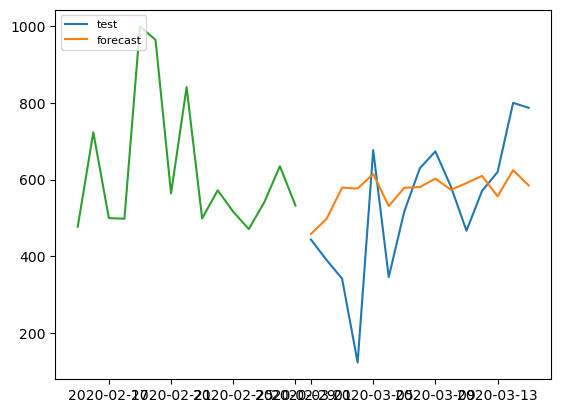

In [613]:
plt.figure 
plt.plot(test.index,test.ActivePower, label='test')
plt.plot(sarima_pred.index, sarima_pred, label='forecast')
plt.plot(history.ActivePower[-15:])
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [614]:
sarima_model = ARIMA(daily_df['ActivePower'], order=(0,0,1), seasonal_order=(1,1,2,7)).fit()
sarima_forecast = sarima_model.forecast(15)
sarima_forecast = pd.DataFrame(sarima_forecast)
idx = pd.date_range(daily_df.index[-1] + timedelta(days=1), periods=15, freq='D')
sarima_forecast.set_index(idx, inplace=True)
sarima_forecast

,predicted_mean
2020-03-16 00:00:00+00:00,681.354151
2020-03-17 00:00:00+00:00,558.746649
2020-03-18 00:00:00+00:00,481.731093
2020-03-19 00:00:00+00:00,630.060079
2020-03-20 00:00:00+00:00,577.077894
2020-03-21 00:00:00+00:00,684.058194
2020-03-22 00:00:00+00:00,682.082037
2020-03-23 00:00:00+00:00,651.437973
2020-03-24 00:00:00+00:00,575.121158
2020-03-25 00:00:00+00:00,510.483921


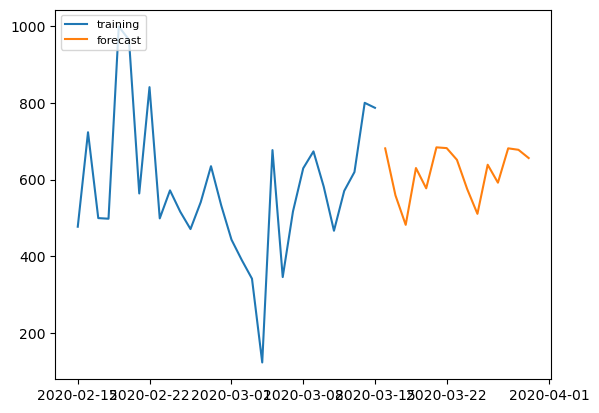

In [615]:
plt.figure 
plt.plot(daily_df.index[-30:],daily_df.ActivePower[-30:], label='training')
plt.plot(sarima_forecast.index, sarima_forecast, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 2. ETS Approach:

In [42]:
len(history['ActivePower'])

790

In [32]:
model_1 = ExponentialSmoothing(history['ActivePower'], trend="add", seasonal="add", seasonal_periods=365, damped_trend=False).fit()
model_2 = ExponentialSmoothing(history['ActivePower'], trend="add", seasonal="mul", seasonal_periods=365, damped_trend=False).fit()
model_3 = ExponentialSmoothing(history['ActivePower'], seasonal="add", seasonal_periods=365, damped_trend=False).fit()
model_4 = ExponentialSmoothing(history['ActivePower'], seasonal="mul", seasonal_periods=365, damped_trend=False).fit()
# damped_trend=True must has trend parameter
# when seasonal = 'mul', values must > 0

In [33]:
pred_1 = pd.DataFrame(model_1.forecast(len(test)))
pred_2 = pd.DataFrame(model_2.forecast(len(test)))
pred_3 = pd.DataFrame(model_3.forecast(len(test)))
pred_4 = pd.DataFrame(model_4.forecast(len(test)))

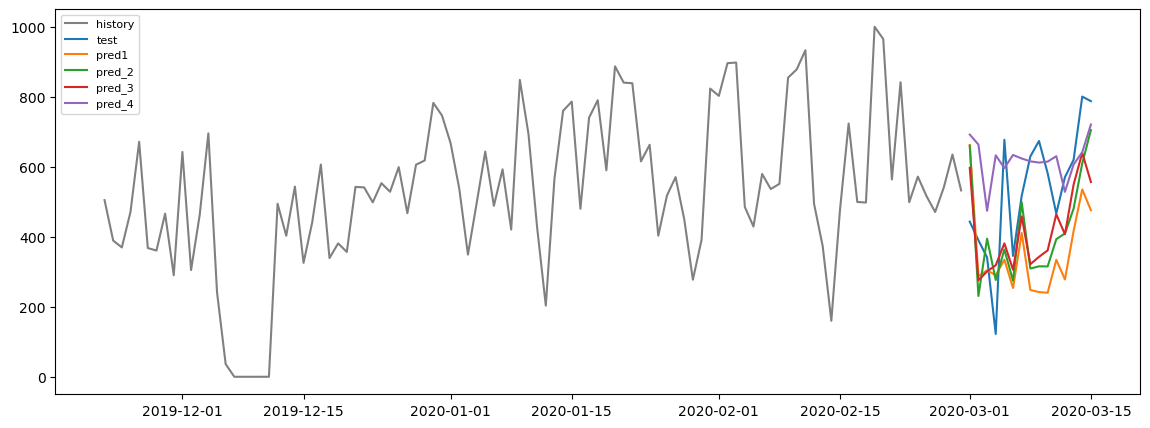

In [35]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
plt.plot(history['ActivePower'][-100:], label='history', color='grey')
plt.plot(test['ActivePower'], label='test')
plt.plot(pred_1, label='pred1')
plt.plot(pred_2, label='pred_2')
plt.plot(pred_3, label='pred_3')
plt.plot(pred_4, label='pred_4')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [37]:
import sklearn.metrics as skmetrics #For evaluation metrics
r1 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_1))
r2 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_2))
r3 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_3))
r4 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], pred_4))
r1,r2,r3,r4

(256.2167177634726, 199.67694277017173, 188.51111085287707, 196.48570226067864)

## 3. Prophet Approach:

In [616]:
prophet_df = daily_df.reset_index()
prophet_df.drop('WindSpeed', axis=1, inplace=True)
prophet_df['Datetime'] = prophet_df['Datetime'].dt.tz_localize(None)
prophet_df.rename(columns={'Datetime':'ds','ActivePower':'y'}, inplace=True)
prophet_df.head()

,ds,y
0,2018-01-01,366.223561
1,2018-01-02,462.550740
2,2018-01-03,454.417752
3,2018-01-04,369.952190
4,2018-01-05,319.446595


In [617]:
history = prophet_df[:-15]
test = prophet_df[-15:]

In [618]:
m1 = Prophet()
m1.fit(history)
future = m1.make_future_dataframe(periods=15)
forecast1 = m1.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

09:34:57 - cmdstanpy - INFO - Chain [1] start processing
09:34:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
728,2020-03-11,534.095094,188.610325,848.038637
729,2020-03-12,557.821184,240.593907,864.508177
730,2020-03-13,509.279244,191.969095,825.687802
731,2020-03-14,514.030427,187.858928,844.687498
732,2020-03-15,504.402720,156.734611,812.258381


In [619]:
np.sqrt(skmetrics.mean_squared_error(forecast1.yhat[-15:], test.y))

180.29547469722536

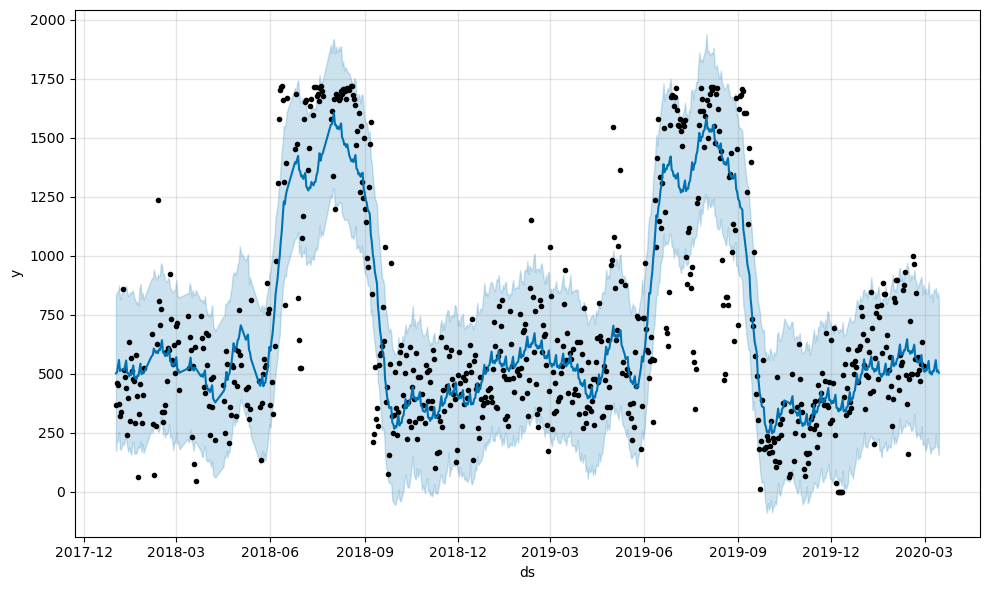

In [620]:
fig1 = m1.plot(forecast1)

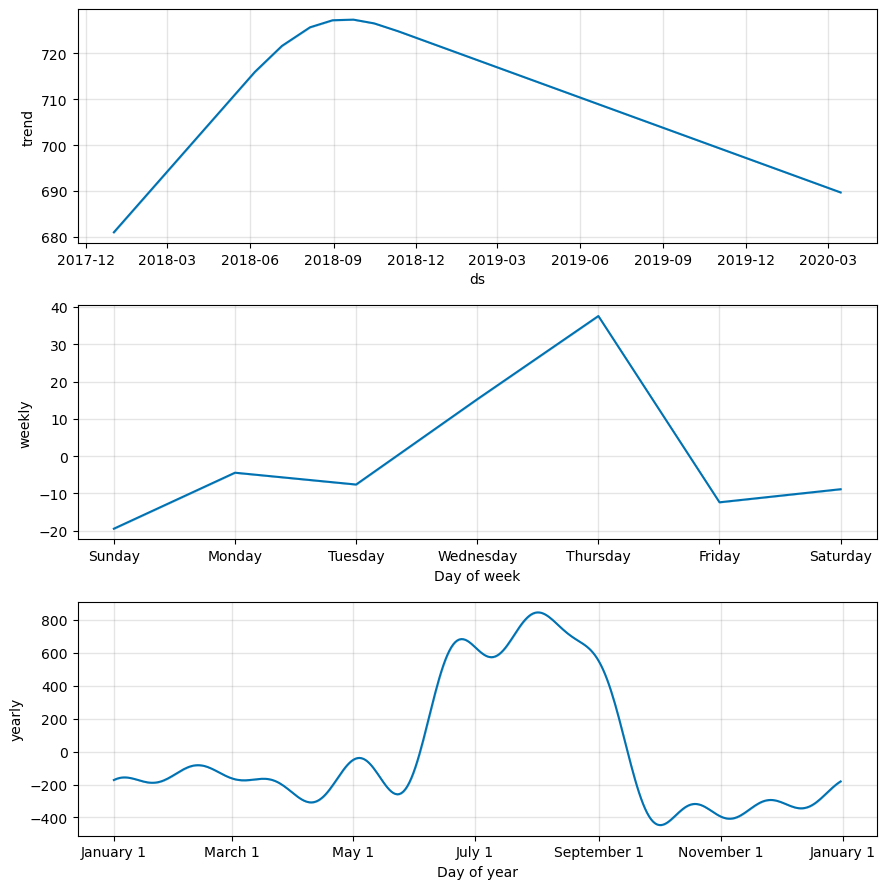

In [621]:
fig1_2 = m1.plot_components(forecast1)

09:35:00 - cmdstanpy - INFO - Chain [1] start processing
09:35:00 - cmdstanpy - INFO - Chain [1] done processing


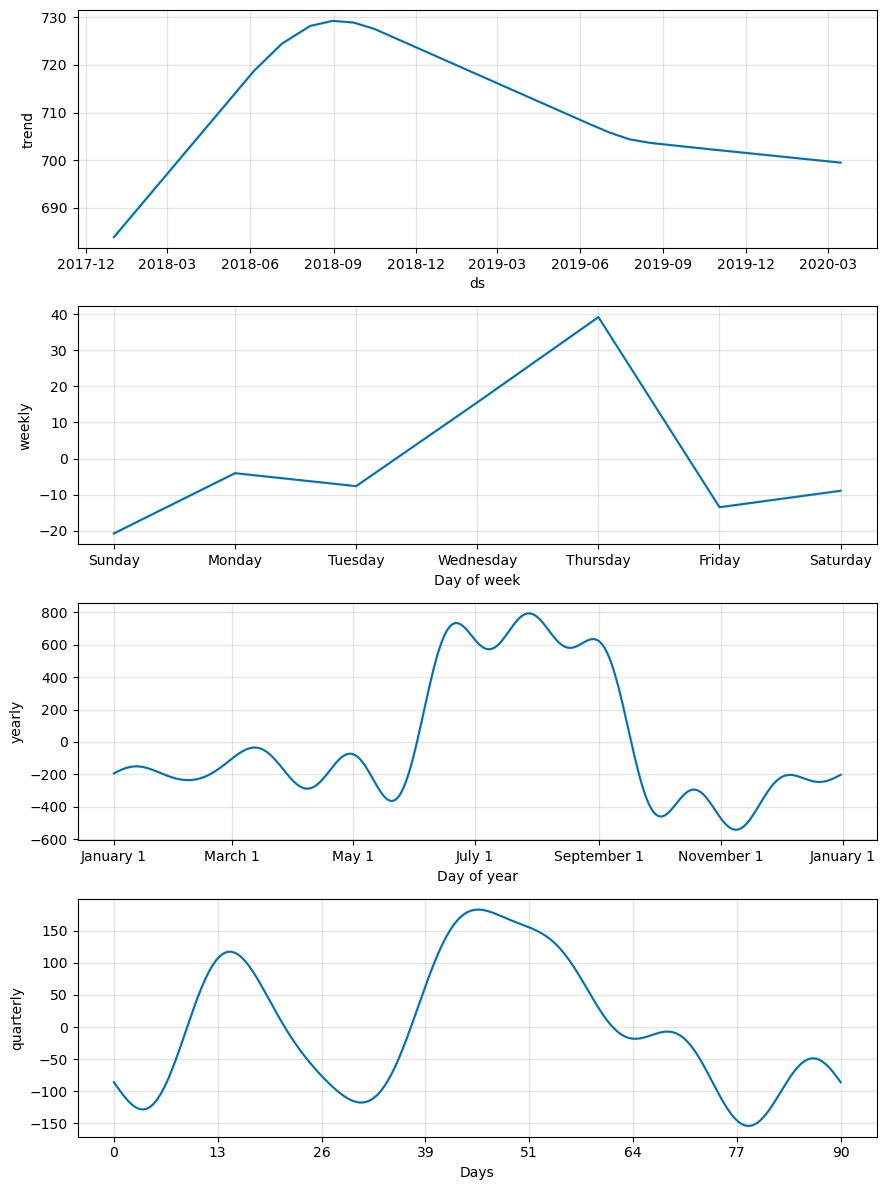

In [622]:
m2 = Prophet()
m2.add_seasonality(name='quarterly', period=90, fourier_order=6)
forecast2 = m2.fit(history).predict(future)
fig = m2.plot_components(forecast2)

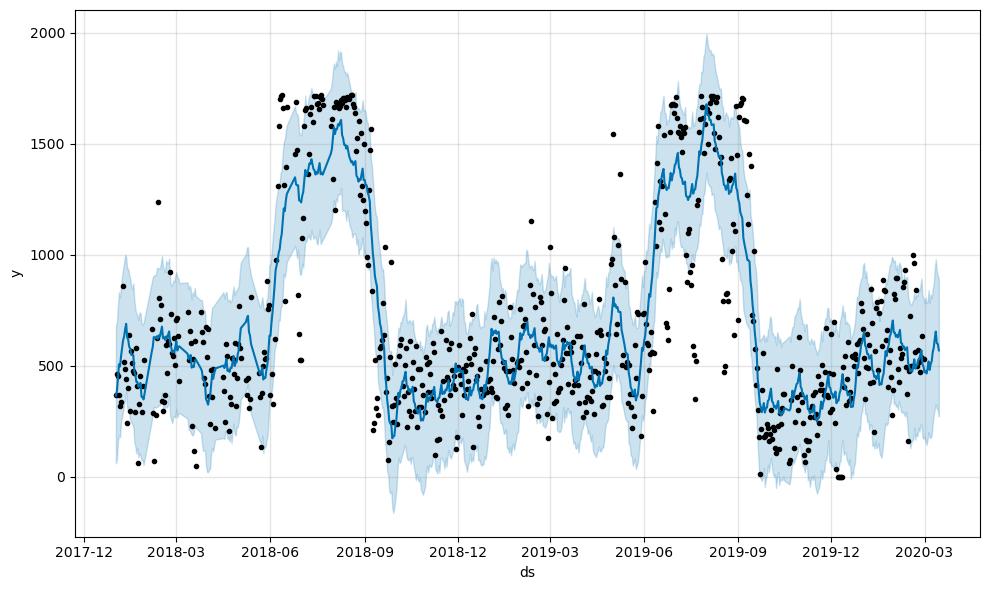

In [623]:
fig2 = m2.plot(forecast2)

In [624]:
np.sqrt(skmetrics.mean_squared_error(forecast2.yhat[-15:], test.y))

151.71092557861252

09:35:03 - cmdstanpy - INFO - Chain [1] start processing
09:35:03 - cmdstanpy - INFO - Chain [1] done processing


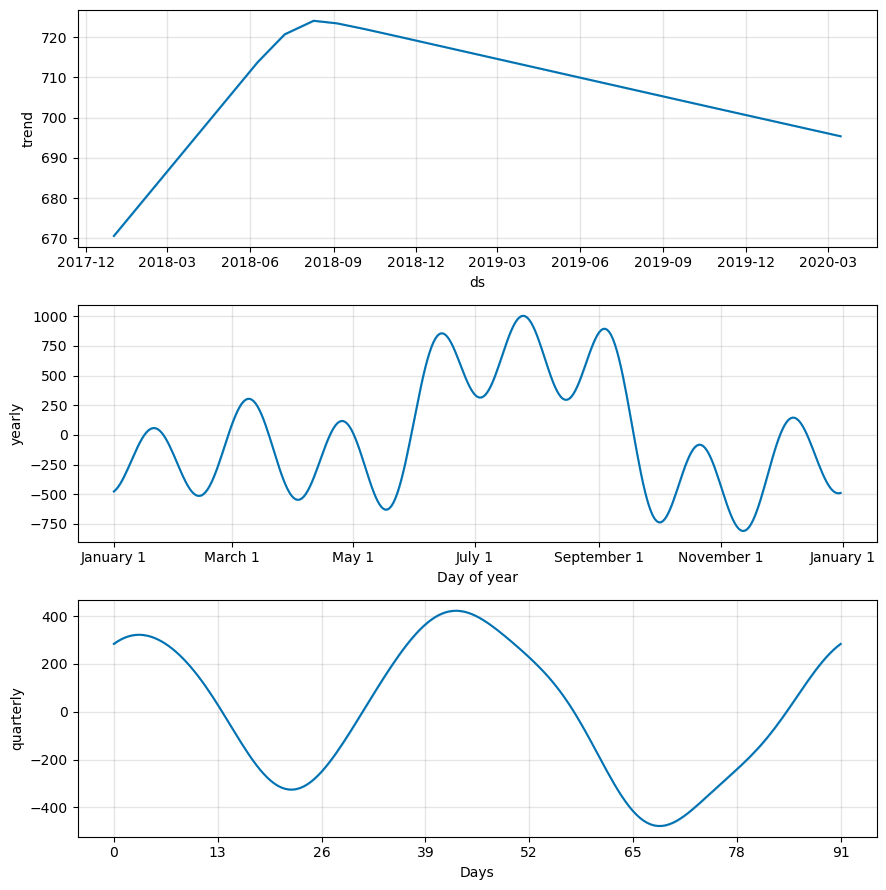

In [625]:
m3 = Prophet(weekly_seasonality=False)
m3.add_seasonality(name='quarterly', period=91, fourier_order=6)
forecast3 = m3.fit(prophet_df).predict(future)
fig3 = m3.plot_components(forecast3)

In [626]:
np.sqrt(skmetrics.mean_squared_error(forecast3.yhat[-15:], test.y))

140.92534481440262

09:35:04 - cmdstanpy - INFO - Chain [1] start processing
09:35:04 - cmdstanpy - INFO - Chain [1] done processing


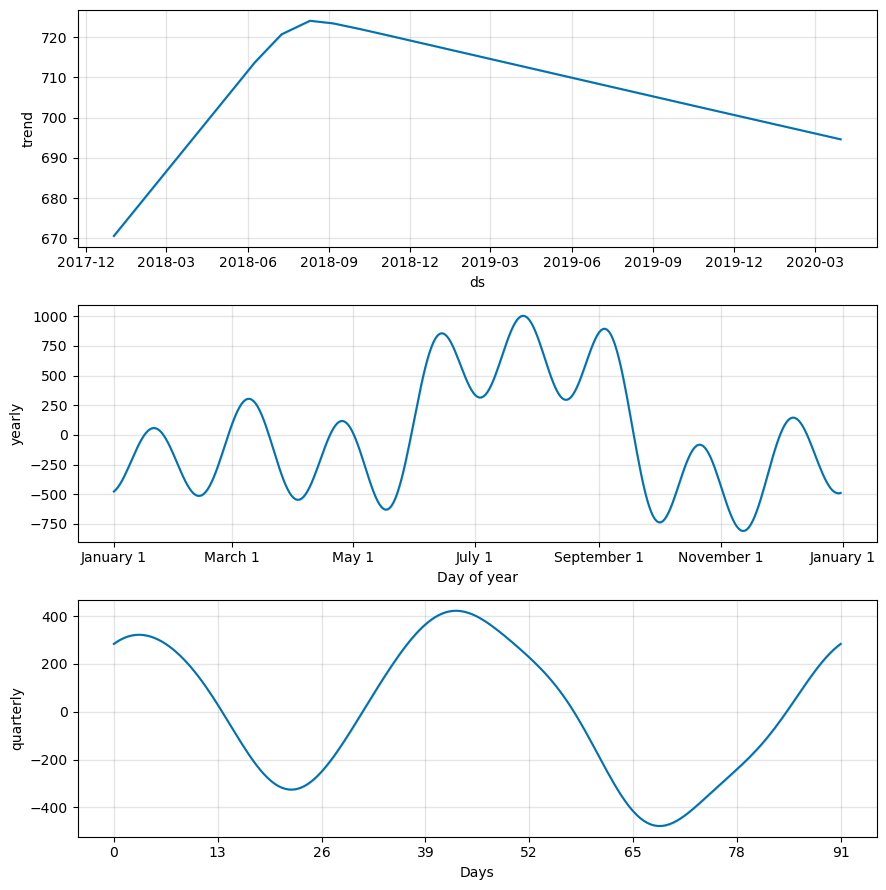

In [627]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='quarterly', period=91, fourier_order=6)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [628]:
forecast = forecast[['ds','yhat']]
final_forecast = forecast[-15:]
final_forecast.rename(columns={'ds':'Date','yhat':'Forecasting'})

,Date,Forecasting
733,2020-03-16,613.417125
734,2020-03-17,601.762284
735,2020-03-18,588.167500
736,2020-03-19,574.245083
737,2020-03-20,561.371762
738,2020-03-21,550.520731
739,2020-03-22,542.166500
740,2020-03-23,536.272229
741,2020-03-24,532.355816
742,2020-03-25,529.618793


In [ ]:
final_forecast.to_csv('test_forecast.csv', index=False)

## 4.Theta Approach:

In [44]:
model_t1 = ThetaModel(history['ActivePower'])
res = model_t1.fit()
predt1 = res.forecast(len(test['ActivePower']))

model_t2= ThetaModel(history['ActivePower'], period=365)
res = model_t2.fit()
predt2 = res.forecast(len(test['ActivePower']))

In [45]:
predt1 = pd.DataFrame(predt1.values, index=pred_3.index)
predt2 = pd.DataFrame(predt2.values, index=pred_3.index)

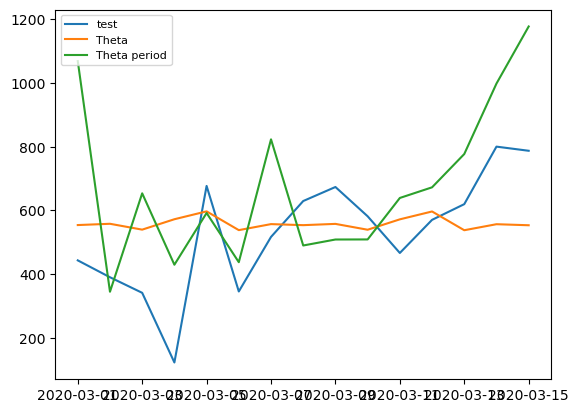

In [46]:
plt.plot(test['ActivePower'], label='test')
plt.plot(predt1, label='Theta')
plt.plot(predt2, label='Theta period')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
r1 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], predt1))
r2 = np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], predt2))
r1,r2

(179.08046791799424, 258.7170262036987)